<center>
    <h1><b><font color="blue"> Notebook 2 - Dataviz</font> </b></h1>
</center>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

#import geopandas as gpd
#from shapely.geometry import Point

from mpl_toolkits.axes_grid1 import make_axes_locatable
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from sklearn.neighbors import DistanceMetric
from math import radians

<hr>
<h1>Chargement des jeux de données :</h1>
<hr>

 - df : données météo en australie sur 10 ans
 - aus_town_gps : localisation des stations météo (x,y) => ce jeu de données va nous permettre de représenter les indicateurs sur une carte et de calculer des distances entre stations météo
 - climatsaus : climat des stations méteo 

In [3]:
df = pd.read_csv(r"D:\dt\DTSPT\Formations\DataScientest\Projet_Meteo\bases\Final\weatherAUS_imputer.csv")

<hr>
<h3>Decouverte du dataframe - Préprocessing</h3>
<hr>

In [7]:
#création de quelques variables de date et conversion de raintoday et raintomorrow en numériques
df['RainToday_Num'] = (df['RainToday'] ==  'Yes')*1
df['RainTomorrow_Num'] = (df['RainTomorrow'] ==  'Yes')*1
df['Date'] = pd.to_datetime(df['Date'])
df['Mois'] = df['Date'].dt.month
df['Trimestre'] = df['Date'].dt.quarter
df['Annee'] = df['Date'].dt.year

<hr>
<h1>Analyse des corrélations :</h1>
<hr>

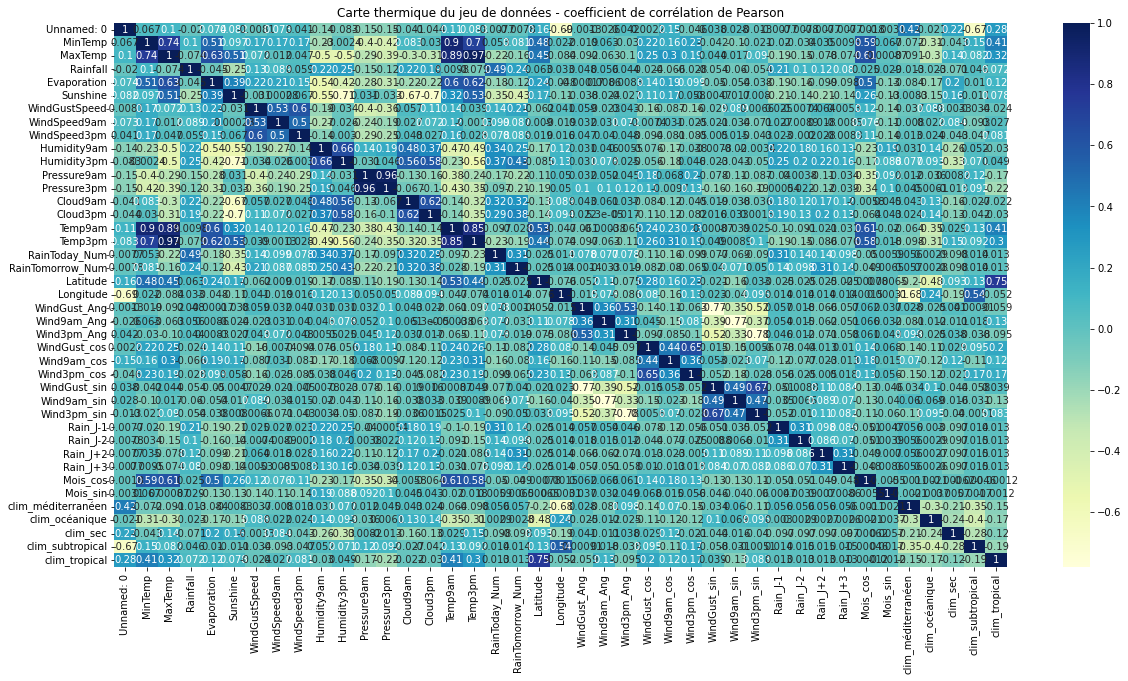

In [5]:
plt.figure( figsize= (20, 10) )
corr = df.drop(["Mois","Trimestre","Annee"],axis=1).corr()
sns.heatmap(corr, cmap="YlGnBu",annot=True)
plt.title("Carte thermique du jeu de données - coefficient de corrélation de Pearson");

Observations :
- Corrélations positives :
    * 60-90% entre les variables correspondant à une même grandeur mesurée (entre les températures, entre les vitesses du vent...).
    * 55-59% entre Evaporation et Temp9am/Temp3pm/MaxTemp
    * 52% entre Cloud9am/Cloud3pm et Humidity3pm
    * 47% entre Sunshine et MaxTemp
- Corrélations négatives :
    * 68-70% entre Sunshine et Cloud9am/Cloud3pm.
    * 63% entre Sunshine et Humidity3pm.
    * 47-56% entre Humidity9am/Humidity3pm et Temp9am/Temp3pm
    * 41-46% entre WindGustSpeed et Pressure9am/Pressure3pm (cas de situations dépressionnaires apportant la pluie ?)


<AxesSubplot:title={'center':'Correlations de Sunshine'}>

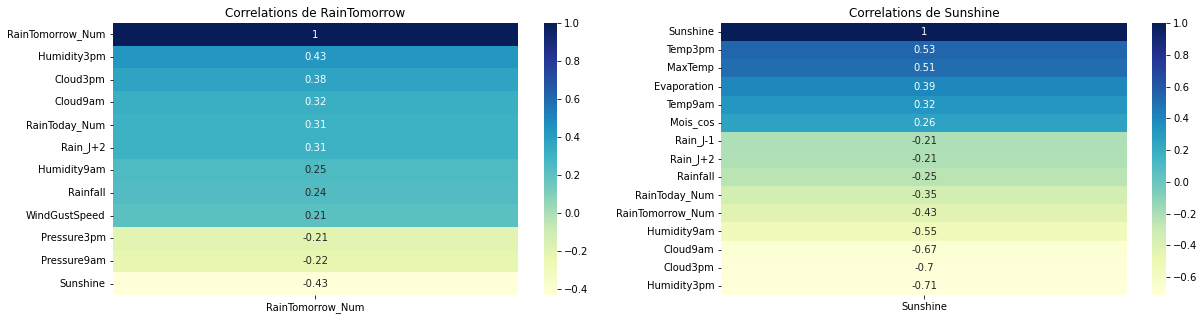

In [6]:
f = plt.figure( figsize= (20, 5) )
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

corr = df.corr()

ax1.title.set_text('Correlations de RainTomorrow')
temp = corr[["RainTomorrow_Num"]].loc[abs(corr["RainTomorrow_Num"]) > 0.2].sort_values(by="RainTomorrow_Num",ascending=False)
sns.heatmap(temp, cmap="YlGnBu",annot=True,ax=ax1)

ax2.title.set_text('Correlations de Sunshine')
temp = corr[["Sunshine"]].loc[abs(corr["Sunshine"]) > 0.2].sort_values(by="Sunshine",ascending=False)
sns.heatmap(temp , cmap="YlGnBu",annot=True,ax=ax2)

- Quelles sont les variables les plus corrélées à RainTomorrow ?
    - Ensoleillement : Sunshine
    - Humidité : 3pm et 9am
    - Couverture nuageuse : 3pm et 9am
    - Pluie du jour : RainToday
    - Pression atmosphérique : Pressure3pm et Pressure9am


- L'ensoleillement (Sunshine) est corrélé à RainTomoroww_num malgré que presque 50% de NA pour cette variable. Quand on regarde les corrélations, on peut imaginer de traiter les NA en régressant Sunshine sur les critères les plus corrélés, à savoir :
    - Couverture nuageuse : 3pm et 9am
    - Humidité : 3pm et 9am
    - Température : Temp3pm, MaxTemp, Temp9am
  

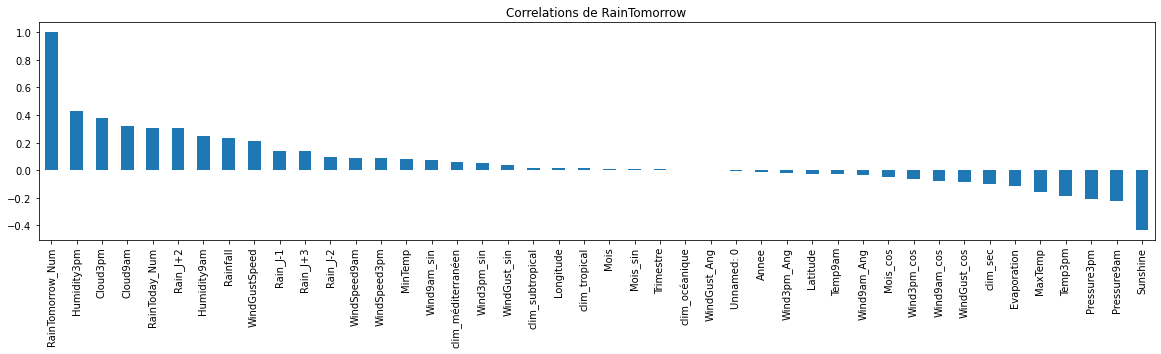

In [7]:
temp = corr["RainTomorrow_Num"].sort_values(ascending=False)

plt.figure(figsize=(20,4))
temp.plot(kind='bar')
plt.title("Correlations de RainTomorrow");

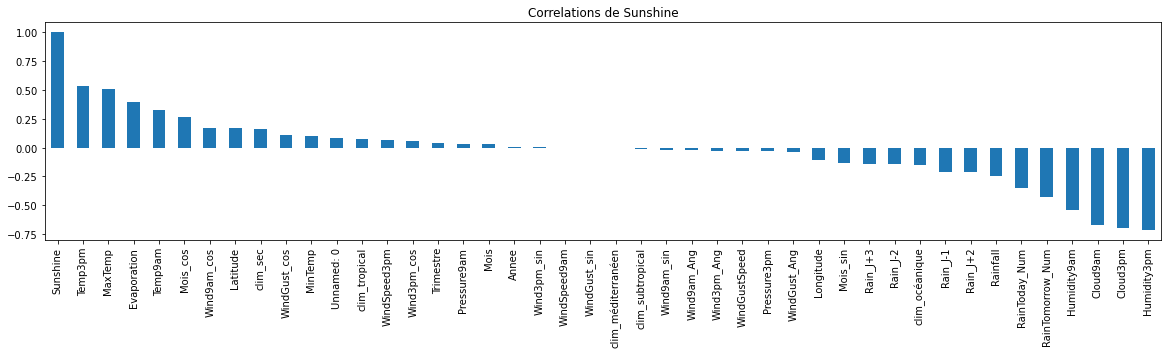

In [8]:
temp = corr["Sunshine"].sort_values(ascending=False)

plt.figure(figsize=(20,4))
temp.plot(kind='bar')
plt.title("Correlations de Sunshine");

<hr>
<h1>Représentation cartographique</h1>
<hr>

Utilisation du module geopandas pour la cartographie (https://geopandas.org/en/stable/gallery/index.html)

In [16]:
Contour_Aus = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
Contour_Aus = Contour_Aus[Contour_Aus["name"] == "Australia"]

stats = df.drop(columns=['Annee', 'Mois','Trimestre'],axis=0).groupby(['Location','Latitude','Longitude','Clim_type']).mean().reset_index()

ListCrit = ['MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','Cloud9am','Cloud3pm','Temp9am','Temp3pm','RainToday_Num']       
for i in ListCrit:
    stats[i] = round(stats[i],2)
stats

geometry = [Point(xy) for xy in zip(stats['Longitude'], stats['Latitude'])]
geo_df = gpd.GeoDataFrame(stats, geometry=geometry)

In [17]:
m = Contour_Aus.explore(
        color = "None",
        width = 800,
        height = 500,
        highlight = False,
        popup = False,
        control_scale=False
)

geo_df.explore(
      m=m,
    width = 800,        
    height = 500,
     column="Rainfall",  # make choropleth based on "BoroName" column
     cmap="coolwarm",
     scheme="quantiles",  # use mapclassify's natural breaks scheme
     legend=True, # show legend
     k=10, # use 10 bins
     #legend_kwds=dict(colorbar=False), # do not use colorbar
     marker_kwds=dict(radius=8)
)
m

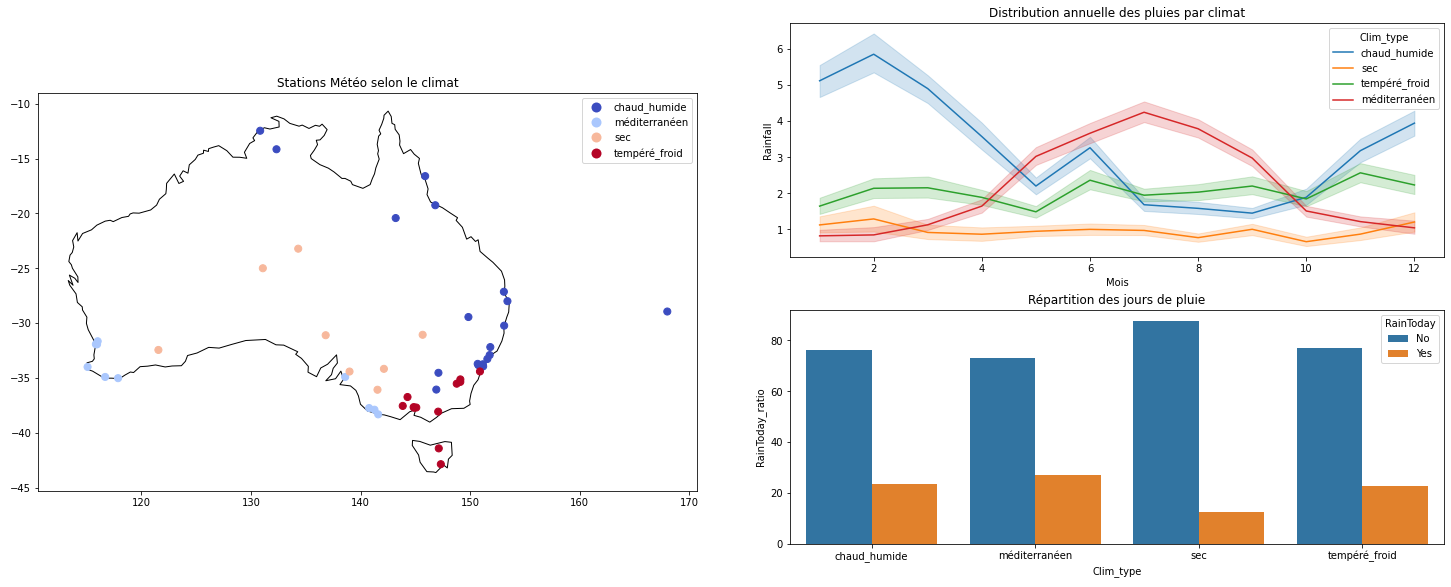

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(20, 8))
subfigs = fig.subfigures(1, 2, wspace=0.07)

ax=subfigs[0].subplots(1, 1)
Contour_Aus.plot(ax=ax,color="None",edgecolor="Black")  
ax.title.set_text('Stations Météo selon le climat')
geo_df.plot(ax=ax,markersize=50, cmap='coolwarm', column="Clim_type",legend=True);

ax2 = subfigs[1].subplots(2, 1)

ax2[0].title.set_text("Distribution annuelle des pluies par climat")
sns.lineplot(ax=ax2[0],data=df, x="Mois", y="Rainfall", hue="Clim_type")

#sns.countplot(ax=ax2[1],x="RainTomorrow", data=df.loc[df.RainToday=='No'], hue='Clim_type') 
#ax2[1].title.set_text('RainToday = No')
#sns.countplot(ax=ax2[1],x="Clim_type",  data=df, hue='RainToday') 
#sns.barplot(ax=ax2[1],x="Clim_type", y="counts",hue="RainToday", data=Comptage)

Comptage = df[['Clim_type','RainToday']].groupby(['Clim_type','RainToday']).size().reset_index(name='counts')
Comptage['RainToday_ratio'] = Comptage.groupby(['Clim_type'])['counts'].transform(lambda x: x*100/x.sum())
ax2[1].title.set_text("Répartition des jours de pluie")
sns.barplot(ax=ax2[1],x="Clim_type", y="RainToday_ratio",hue="RainToday", data=Comptage);

Observations : 

- Les stations météo d'Australie sont regroupées en 4 climats différents:
    - méditerrannéen : stations du sud ouest et du sud centre
    - chaud_humide (tropical et subtropical humide) => côte est du pays
    - tempéré_froid (tempéré océanique + montagnard) => plutôt sud est
    - sec (chaud et semi-aride, voire aride) => intérieur du pays

- La distribution mensuelle des précipitations illustre bien les différences de climat (mousson estivale pour le climat tropical, hivernale pour le climat méditerranéen)

- Pour les stations au climat sec, on a 9% de jours de pluie alors que pour les autres on est aux alentours de 22, 23%.
  

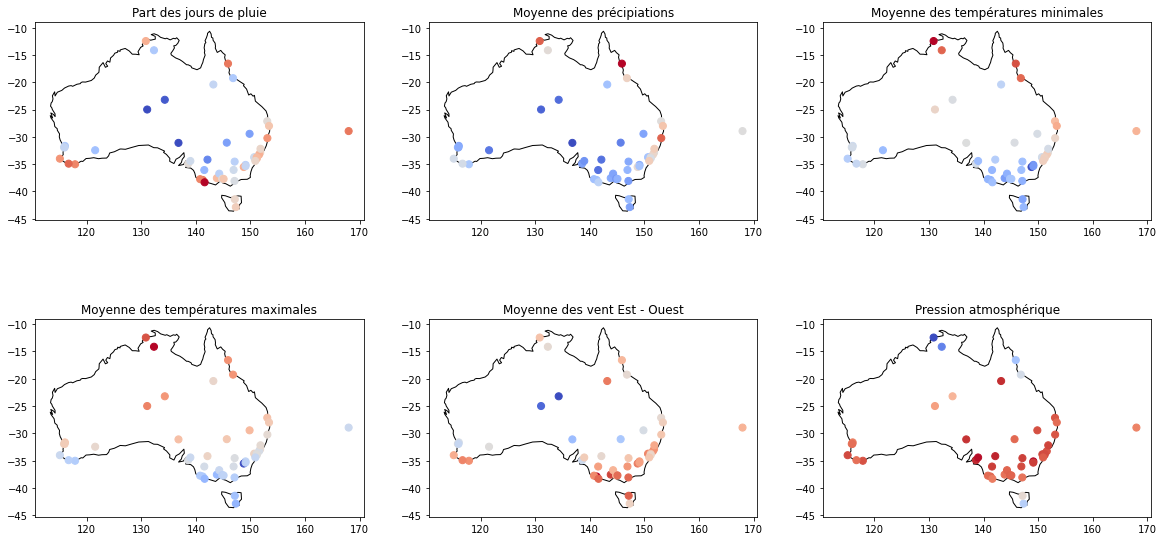

In [19]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
ax4 = f.add_subplot(234)
ax5 = f.add_subplot(235)
ax6 = f.add_subplot(236)

Contour_Aus.plot(ax=ax,color="None",edgecolor="Black")  
ax.title.set_text('Part des jours de pluie')
geo_df.plot(ax=ax, markersize=50, cmap='coolwarm', column="RainToday_Num");

Contour_Aus.plot(ax=ax2,color="None",edgecolor="Black")  
ax2.title.set_text('Moyenne des précipiations')
geo_df.plot(ax=ax2, markersize=50, cmap='coolwarm', column="Rainfall");

Contour_Aus.plot(ax=ax3,color="None",edgecolor="Black")  
ax3.title.set_text('Moyenne des températures minimales')
geo_df.plot(ax=ax3, markersize=50, cmap='coolwarm', column="MinTemp");

Contour_Aus.plot(ax=ax4,color="None",edgecolor="Black")  
ax4.title.set_text('Moyenne des températures maximales')
geo_df.plot(ax=ax4, markersize=50, cmap='coolwarm', column="MaxTemp");

Contour_Aus.plot(ax=ax5,color="None",edgecolor="Black")  
ax5.title.set_text('Moyenne des vent Est - Ouest')
geo_df.plot(ax=ax5, markersize=50, cmap='coolwarm', column="Humidity9am");

Contour_Aus.plot(ax=ax6,color="None",edgecolor="Black")  
ax6.title.set_text('Pression atmosphérique')
geo_df.plot(ax=ax6, markersize=50, cmap='coolwarm', column="Pressure9am");


<hr>
<h1>Influence pour prédire la pluie</h1>
<hr>

<hr>
<h3>Au global</h3>
<hr>

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='LogEvaporation', ylabel='Count'>

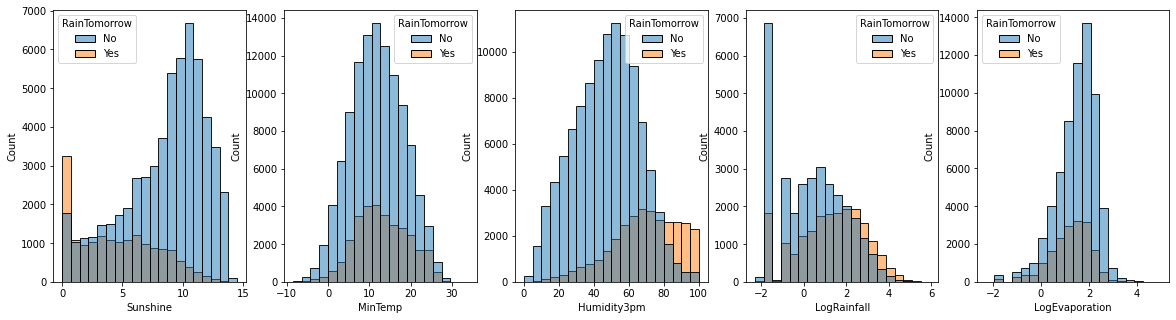

In [20]:
df["LogRainfall"] = np.log(df["Rainfall"])
df["LogEvaporation"] = np.log(df["Evaporation"])

plt.figure(figsize=(20,5))
plt.subplot(151)
sns.histplot(data=df, x="Sunshine",hue="RainTomorrow",bins=20, multiple="layer", thresh=None)
plt.subplot(152)
sns.histplot(data=df, x="MinTemp",hue="RainTomorrow",bins=20, thresh=None)
plt.subplot(153)
sns.histplot(data=df, x="Humidity3pm",hue="RainTomorrow",bins=20)
plt.subplot(154)
sns.histplot(data=df, x="LogRainfall",hue="RainTomorrow",bins=20)
plt.subplot(155)
sns.histplot(data=df, x="LogEvaporation",hue="RainTomorrow",bins=20)

Constats :

* La distribution de Sunshine et Humidity3pm est bien différente selon RainTomorrow
* Pour MinTemp, la distribution est relativement similaire
* Pour Rainfall et Evaporation, on passe au log pour neutraliser l'influence des valeurs extremes. On voit aussi l'influence plus importante de Rainfall sur RainTomorrow (distribution différentes)

<hr>
<h3>Selon les climats</h3>
<hr>

Influence des variables atmosphériques sur RainTomorrow pour chaque climat


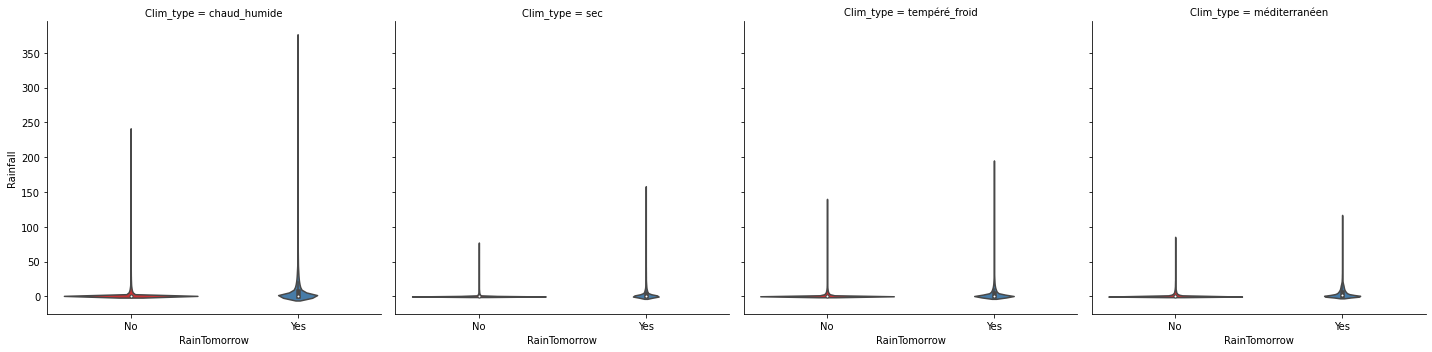

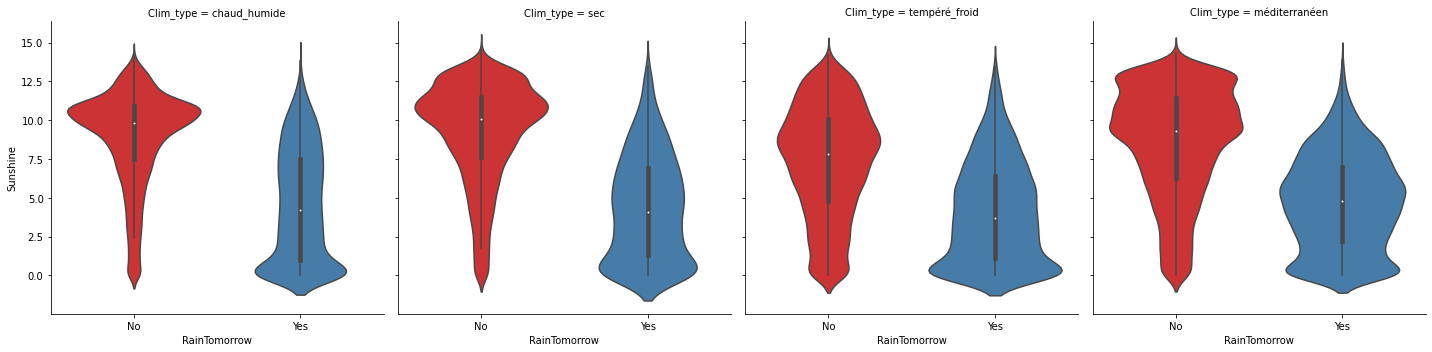

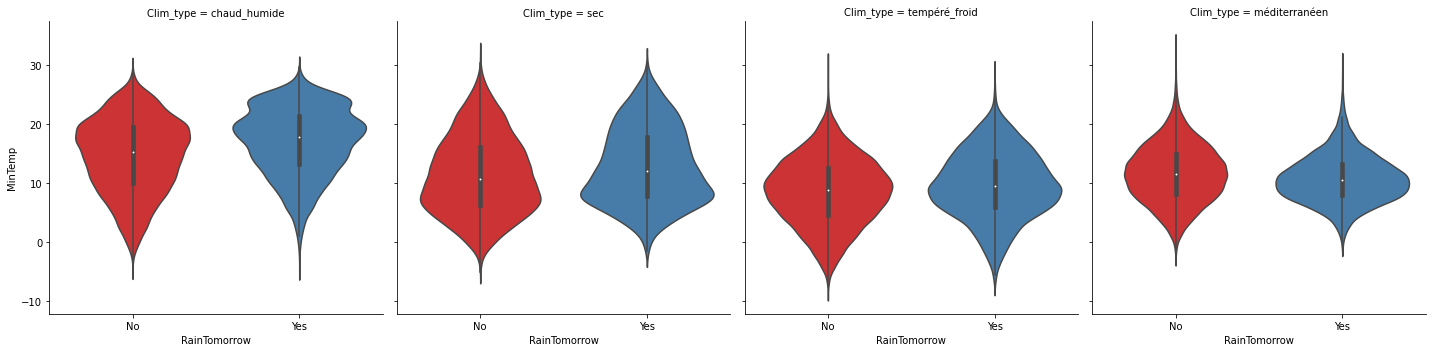

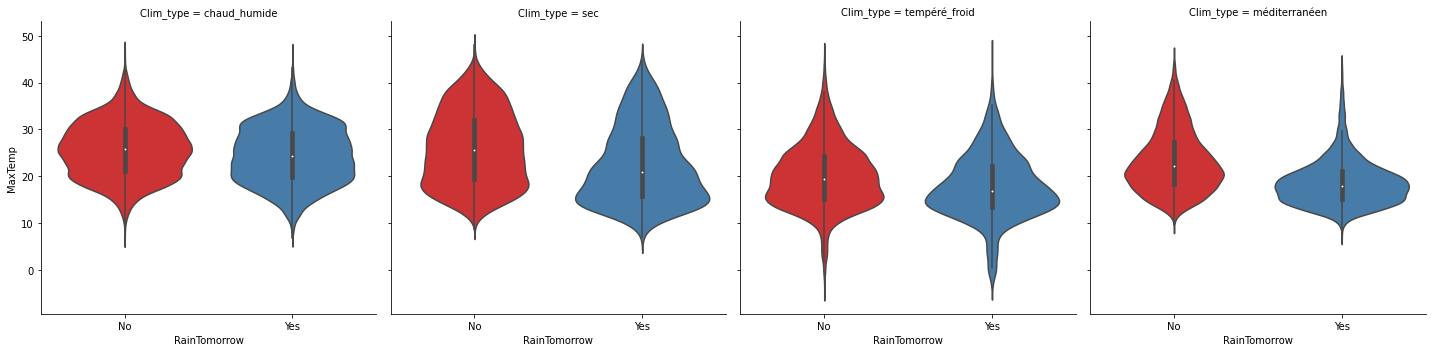

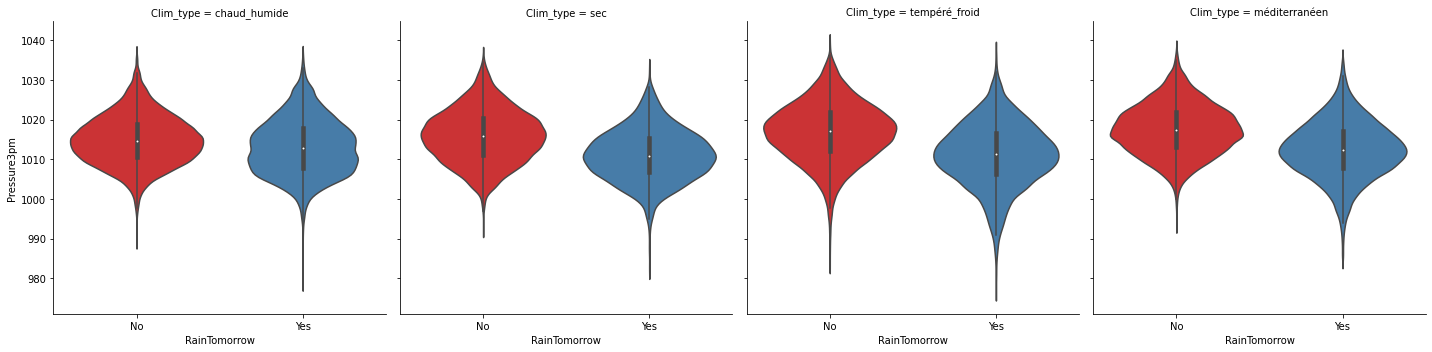

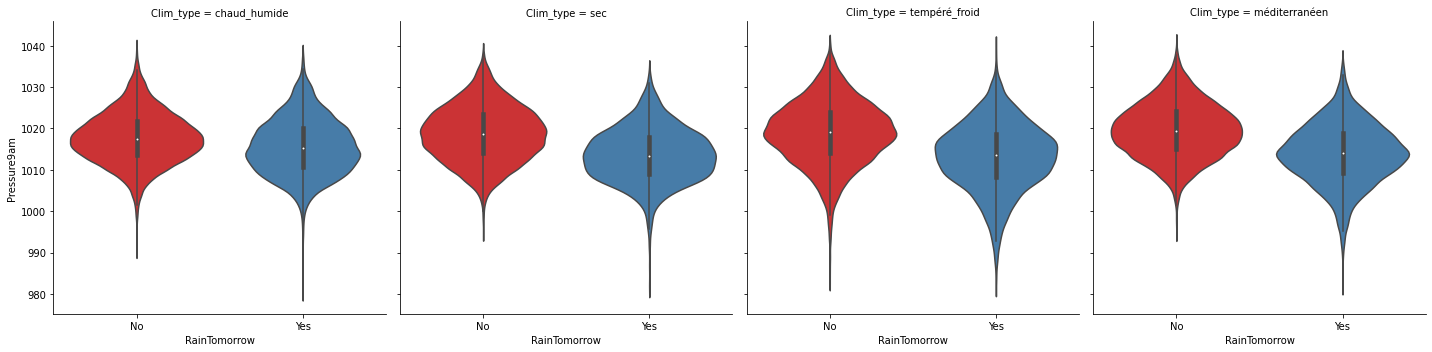

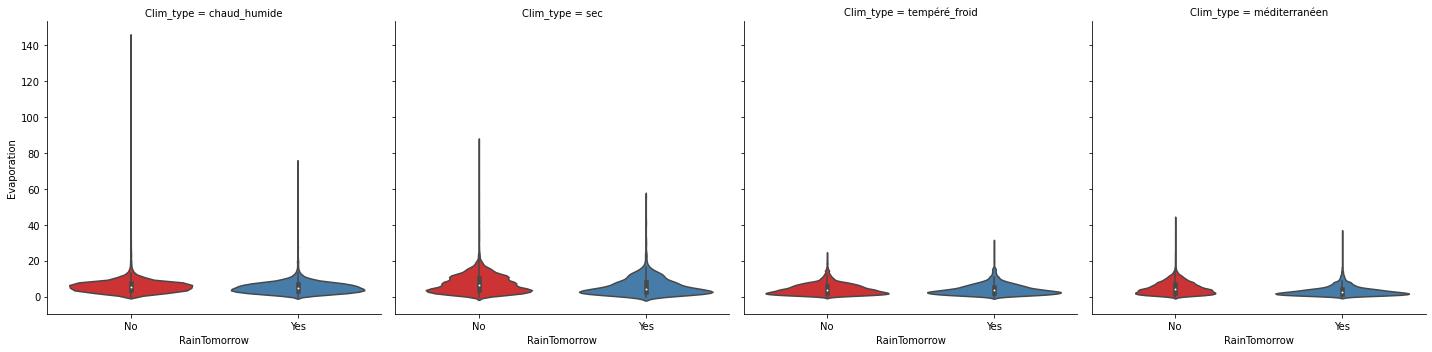

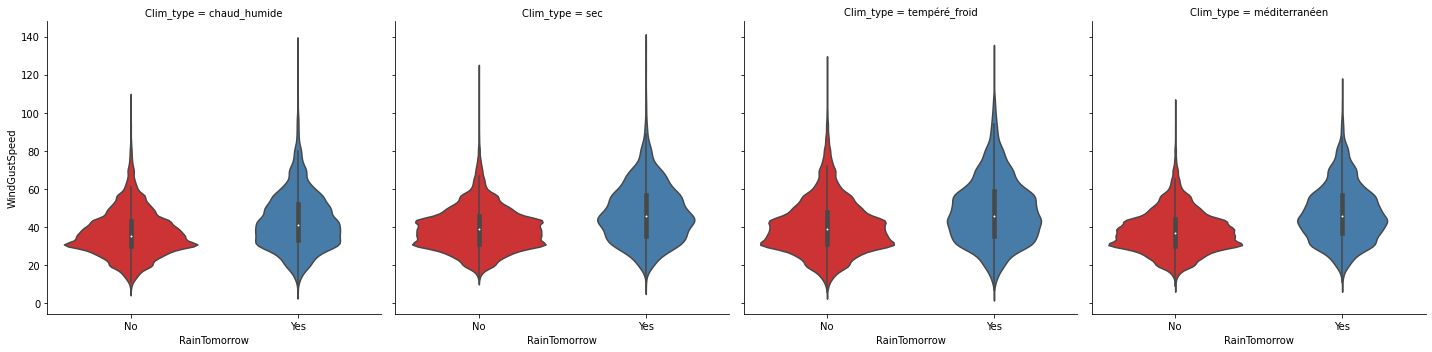

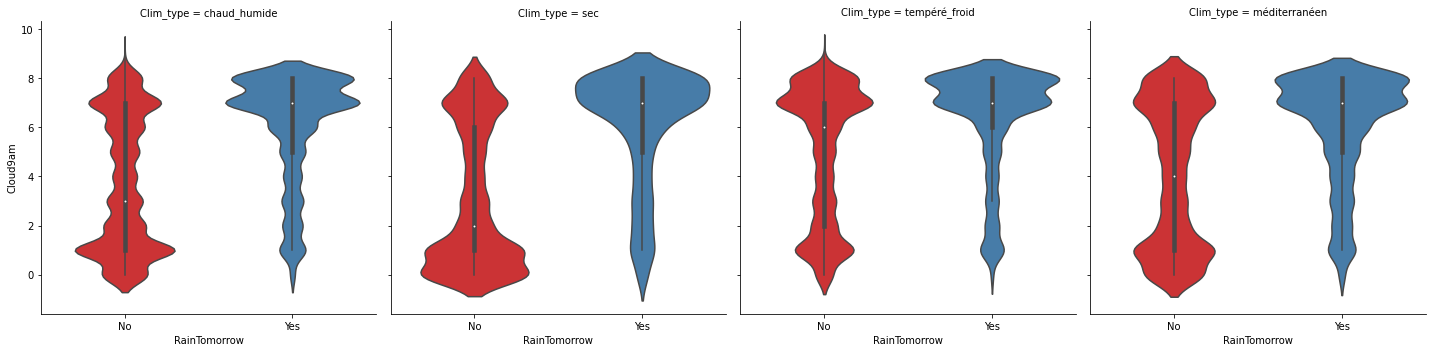

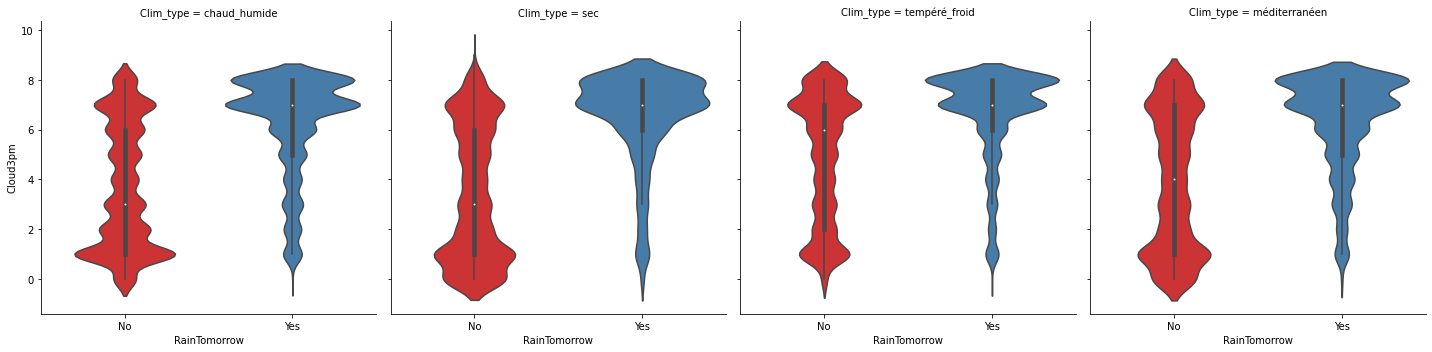

In [21]:
print("Influence des variables atmosphériques sur RainTomorrow pour chaque climat")

sns.catplot(data=df, y="Rainfall", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Sunshine", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="MinTemp", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="MaxTemp", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Pressure3pm", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Pressure9am", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Evaporation", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="WindGustSpeed", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Cloud9am", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1')
sns.catplot(data=df, y="Cloud3pm", x="RainTomorrow", col="Clim_type", kind='violin', palette='Set1');

Observations :

Rainfall : Des valeurs extrêmes pour tous les climats, particulièrement importantes pour le climats chaud et humide. L’influence de RainToday sur RainTomorrow permettra de préciser ces observations (voir plus loin).

Sunshine : Les pluies sont associées à un ensoleillement plus faible la veille, effet moins marqué pour le climat tempéré froid.

Cloud9am/3pm : L’aspect bosselé des violons s’explique par la nature discrète de ces variables.
La couverture nuageuse est plus importante en cas de pluie le lendemain. L’inverse n’est pas observé, ce qui peut s’expliquer par la présence de nombreux jours de grisaille non pluvieux, en particulier sous les climats tempéré et méditerranéen.

Max/MinTemp : Pas d’association marquée entre température et pluie le lendemain. On observe plus de valeurs extrêmes négatives en climat tempéré.

Evaporate : l’association entre évaporation et pluie n’est pas évidente. Les valeurs extrême s’observent surtout sous le climat chaud humide et le climat sec. 

Pressure9am/3pm : On observe une légère association entre valeurs faibles de pression atmosphérique et pluie le lendemain (situation dépressionaire), les valeurs extrêmes faibles étant presque toujours associées à de pluie.

WindGustSpeed : La forme des violons diffèrent entre les deux modalités : ils sont plus étalés avec plus de valeurs extrêmes positives en cas de pluie.

<hr>
<h3>Influence de la pluie du jour sur la pluie du lendemain</h3>
<hr>

Test du chi2 entre RainToday et RainTomorrow :
statistique du test chi2 = 13799.479649324368
p-value du test chi2 = 0.0
degré de liberté du test chi2 = 1
V de Cramer : 0.3079961727173337


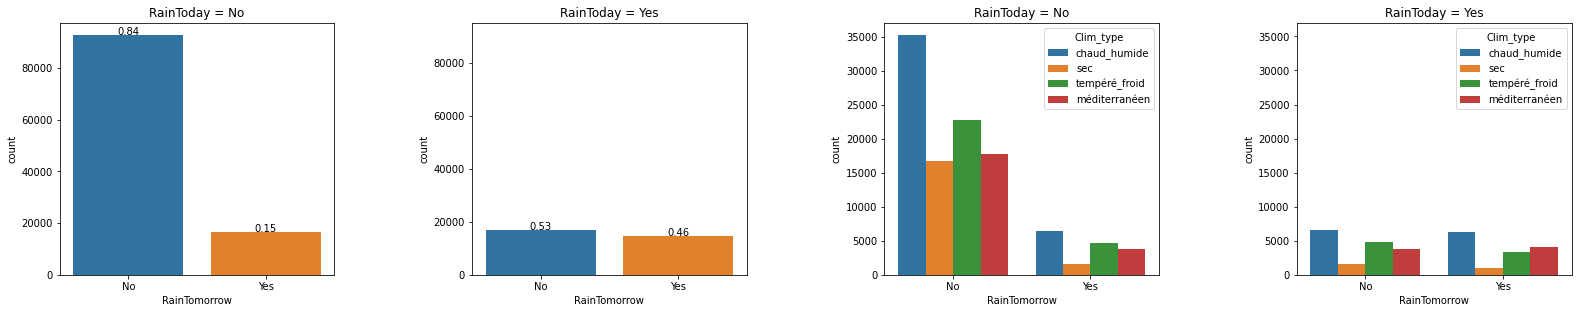

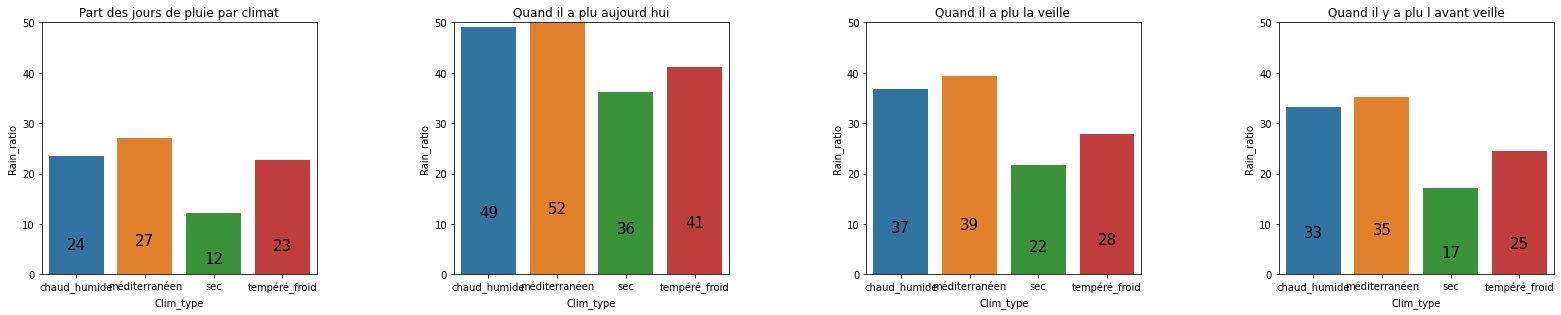

In [22]:

#table de contingence entre RainToday et RainTomorrow
contingence = pd.crosstab(df["RainToday"],df["RainTomorrow"])

#test du chi2 entre RainToday et RainTomorrow
from scipy.stats import chi2_contingency

chi2 = chi2_contingency(contingence)
print("Test du chi2 entre RainToday et RainTomorrow :")
print("statistique du test chi2 =",chi2[0])
print("p-value du test chi2 =",chi2[1])
print("degré de liberté du test chi2 =",chi2[2])

#calcul du V de Cramer
def V_Cramer (table, N):
    """
    Calcule le V de Cramer corrigé d'un tableau de contingence
    
    Paramètres :
    table : tableau de contingence
    N : nombre d'observations
    
    Renvoie : la valeur du V de Cramer
    """
    
    chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi2 = np.max([0 , chi2/N - (k-1)*(r-1)/(N-1)])
    ktil = k - (k-1)**2/(N-1)
    rtil = r - (r-1)**2/(N-1)
    V = np.sqrt( phi2 / np.min([ktil-1 , rtil-1]))
    return V

print("V de Cramer :", V_Cramer(contingence,df.shape[0]))


plt.figure(figsize=(30,5))
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0)

plt.subplot(141)
total = float(len(df.loc[df.RainToday=='No']))
ax = sns.countplot(x="RainTomorrow", data=df.loc[df.RainToday=='No']) 
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.title('RainToday = No')
   
plt.subplot(142)
total = float(len(df.loc[df.RainToday=='Yes']))
ax = sns.countplot(x="RainTomorrow", data=df.loc[df.RainToday=='Yes'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.ylim([0,95000])
plt.title('RainToday = Yes')


#Distribution des valeurs de RainTomorrow en fonction de RainToday pa climat

plt.subplot(143)
sns.countplot(x="RainTomorrow", data=df.loc[df.RainToday=='No'], hue='Clim_type') 
plt.title('RainToday = No')
    
plt.subplot(144)
sns.countplot(x="RainTomorrow", data=df.loc[df.RainToday=='Yes'], hue='Clim_type')
plt.ylim([0,37000])
plt.title('RainToday = Yes');
plt.show()

#_________________________________________________________________________

df= df.sort_values(["Location","Date"])
df["Rain_J_1"] = df["RainToday"].shift(1)
df["Rain_J_2"] = df["RainToday"].shift(2)

plt.figure(figsize=(30,5))
plt.gcf().subplots_adjust(left = 0.2, bottom = 0.2, right = 0.9, top = 0.9, wspace = 0.5, hspace = 0)

plt.subplot(141)
plt.title('Part des jours de pluie par climat')
plt.ylim([0,50])
Comptage = df[['Clim_type','RainTomorrow']].groupby(['Clim_type','RainTomorrow']).size().reset_index(name='counts')
Comptage['Rain_ratio'] = Comptage.groupby(['Clim_type'])['counts'].transform(lambda x: x*100/x.sum())

g = sns.barplot(x="Clim_type", y="Rain_ratio",data=Comptage[Comptage["RainTomorrow"] == "Yes"])
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/4), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 0), 
                   textcoords = 'offset points')

plt.subplot(142)
plt.title('Quand il a plu aujourd hui')
plt.ylim([0,50])
Comptage = df[['Clim_type','RainTomorrow','RainToday']].groupby(['Clim_type','RainTomorrow','RainToday']).size().reset_index(name='counts')
Comptage['Rain_ratio'] = Comptage.groupby(['Clim_type','RainTomorrow'])['counts'].transform(lambda x: x*100/x.sum())

g = sns.barplot(x="Clim_type", y="Rain_ratio",data=Comptage[(Comptage["RainToday"] == "Yes")&(Comptage["RainTomorrow"] == "Yes")])
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/4), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 0), 
                   textcoords = 'offset points')
    
plt.subplot(143)
plt.title('Quand il a plu la veille ')
plt.ylim([0,50])
Comptage = df[['Clim_type','RainTomorrow','Rain_J_1']].groupby(['Clim_type','RainTomorrow','Rain_J_1']).size().reset_index(name='counts')
Comptage['Rain_ratio'] = Comptage.groupby(['Clim_type','RainTomorrow'])['counts'].transform(lambda x: x*100/x.sum())

g = sns.barplot(x="Clim_type", y="Rain_ratio",data=Comptage[(Comptage["Rain_J_1"] == "Yes")&(Comptage["RainTomorrow"] == "Yes")])
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/4), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 0), 
                   textcoords = 'offset points')    
    
plt.subplot(144)
plt.title('Quand il y a plu l avant veille')
plt.ylim([0,50])
Comptage = df[['Clim_type','RainTomorrow','Rain_J_2']].groupby(['Clim_type','RainTomorrow','Rain_J_2']).size().reset_index(name='counts')
Comptage['Rain_ratio'] = Comptage.groupby(['Clim_type','RainTomorrow'])['counts'].transform(lambda x: x*100/x.sum())

g = sns.barplot(x="Clim_type", y="Rain_ratio",data=Comptage[(Comptage["Rain_J_2"] == "Yes")&(Comptage["RainTomorrow"] == "Yes")])
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/4), 
                   ha = 'center', va = 'center', 
                   size=15,
                   xytext = (0, 0), 
                   textcoords = 'offset points') 



Interprétation :

S’il ne pleut pas aujourd’hui, on n’observera pas de pluie le lendemain dans 84% des cas. La réciproque n’est pas vraie : s’il pleut aujourd’hui, la pluie ne persistera que dans la moitié des cas environ.

Cette tendance s’observe pour tous les climats (y compris quand on regarde si il a plus les jours d'avant (cf graphes ci dessous)



<hr>
<h3>Influence des vents sur la pluie</h3>
<hr>

Pour simplifier :

Hypothèses :
- La direction des vents dominants diffère d'un climat à l'autre.
- La direction des vents n'a pas la même influence sur la pluie selon le climat.

Pour tester ces hypothèses, on se concentre sur deux climats différents :
- Le climat chaud_humide (côte est, nord-est, océan Pacifique)
- Le climat méditerranéen (côte sud, sud-ouest, océan Indien)

On étudiera uniquement la direction W-E de la rafale la plus forte (WindGust_cos).

test de corrélation - climat méditerranéen
Test du chi2 entre WindGust_cos et RainTomorrow :
statistique du test chi2 = 3279.656290070576
p-value du test chi2 = 0.0
degré de liberté du test chi2 = 15
V de Cramer : 0.3270806835666447

test de corrélation - climat chaud_humide
Test du chi2 entre WindGust_cos et RainTomorrow :
statistique du test chi2 = 1090.69615350217
p-value du test chi2 = 4.783922207956298e-223
degré de liberté du test chi2 = 15
V de Cramer : 0.1378338816296785

Distribution annuelle de la direction W/E de la rafale la plus forte en fonction de RainTomorrow


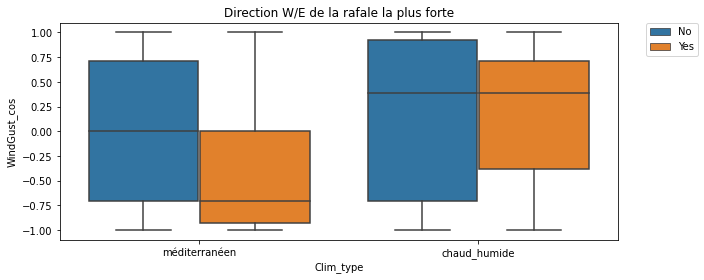

<Figure size 1440x288 with 0 Axes>

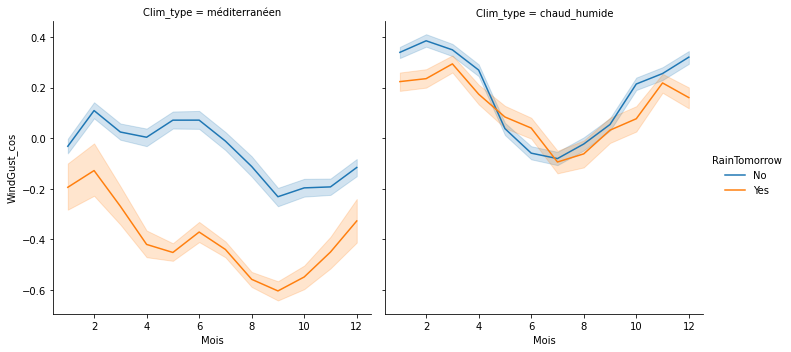

In [23]:
#_________________________________________________________________________

print("test de corrélation - climat méditerranéen")

df_med = df[df.Clim_type == 'méditerranéen']
#table de contingence entre RainToday et RainTomorrow
contingence_med = pd.crosstab(df_med["WindGust_cos"],df_med["RainTomorrow"])

#test du chi2 entre RainToday et RainTomorrow
chi2_med = chi2_contingency(contingence_med)
print("Test du chi2 entre WindGust_cos et RainTomorrow :")
print("statistique du test chi2 =",chi2_med[0])
print("p-value du test chi2 =",chi2_med[1])
print("degré de liberté du test chi2 =",chi2_med[2])

#calcul du V de Cramer
print("V de Cramer :", V_Cramer(contingence_med,df_med.shape[0]))
print("")

#_________________________________________________________________________

print("test de corrélation - climat chaud_humide")

df_trop = df[df.Clim_type == 'chaud_humide']
#table de contingence entre RainToday et RainTomorrow
contingence_trop = pd.crosstab(df_trop["WindGust_cos"],df_trop["RainTomorrow"])

#test du chi2 entre RainToday et RainTomorrow
chi2_trop = chi2_contingency(contingence_trop)
print("Test du chi2 entre WindGust_cos et RainTomorrow :")
print("statistique du test chi2 =",chi2_trop[0])
print("p-value du test chi2 =",chi2_trop[1])
print("degré de liberté du test chi2 =",chi2_trop[2])

#calcul du V de Cramer
print("V de Cramer :", V_Cramer(contingence_trop,df_trop.shape[0]))
print("")

#_________________________________________________________________________


#réduction du df à ces deux climats
df2 = df[(df.Clim_type == 'méditerranéen') | (df.Clim_type == 'chaud_humide')]


#Distribution de WindGust_cos en fonction du climat et de RainTomorrow
fig = plt.figure(figsize=(10,4))
plt.title("Direction W/E de la rafale la plus forte")
sns.boxplot(data=df2, y="WindGust_cos", x="Clim_type", hue="RainTomorrow")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

fig = plt.figure(figsize=(20,4))
#Distribution annuelle de la direction W/E de la rafale la plus forte
print("Distribution annuelle de la direction W/E de la rafale la plus forte en fonction de RainTomorrow")
sns.relplot(data=df2, x="Mois", y="WindGust_cos", hue="RainTomorrow", col='Clim_type', kind='line')
plt.ylabel("Direction W-E (WindGust_cos)");

Observations : 
La direction W-E de la rafale la plus forte varie au cours de l’année. En climat méditerranéen, le cosinus est plus faible en cas de pluie le lendemain, ce qui traduit une direction du vent provenant plutôt de l’ouest.

Conclusion des tests statistiques du Chi2 : 
La direction ouest-est de la rafale la plus forte est corrélée à la pluie en climat méditerranéen (p-value = 0) et en climat chaud_humide (p_value = 0) mais la corrélation est plus importante en climat méditerranéen (V de Cramer plus élevé).

Nos hypothèses sont validées.

Interprétation : 
Les régions méditerranéennes sont situées sur la côte sud ou sud-ouest de l’île (océan Indien). Les pluies sont apportées par des fronts nuageux venant de l'ouest.

Le phénomène est d’autant plus marqué en hiver, en raison de la migration vers le nord de la crête subtropicale.  Il s’agit d’une ceinture de hautes-pressions (anticyclones) qui permet le maintien d’un temps sec sur le sud du pays en été. Pendant l’hiver austral, cette ceinture remonte vers le nord, donc la côte sud de l’Australie se retrouve sous cette crête, ce qui permet aux fronts froids dépressionnaires situés sous la ceinture de parcourir le sud du pays, apportant fréquemment des pluies.

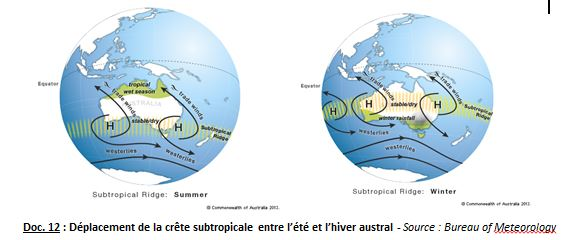